<a href="https://colab.research.google.com/github/sulova/GEE/blob/main/Landsat_LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the earthengine-api.
!pip install -q earthengine-api

# Import the Earth Engine library.
import ee

# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=D1qQ3tnada7Z3klY5nZFsmdtfhROFSUH4RZChCXPjTc&tc=DlNs0aT3WtnkGG2JsBG3NNi2AG8ixLs8hbCkclZ1YKc&cc=v-kLJx4W5ou4HT_2dP8H66JZg_UDTPIbeE927900Mp4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdccX2N_BGzemBLKiK4qLRx8Hfc-ukbEGtCTeuXAzzzor1wfGdUREmo

Successfully saved authorization token.


# Install and import the python libraries
Geemap is the python package for interactive mapping with Google Earth Engine (GEE).


In [2]:
# Install geemap library.
%%capture
!pip install geemap

The pprint library makes it easier to read some formated data structures 

In [3]:
# Import the geemap library.
import geemap

# Import the ppring library.
import pprint

In [4]:
AOI = ee.Geometry.Polygon([[12.43068076963608, 55.73818538794754],
          [12.43068076963608, 55.60110149987755],
          [12.724908369733736, 55.60110149987755],
          [12.724908369733736, 55.73818538794754]])
# Add the AOI to the Map.
Map = geemap.Map(height = 400, draw = True)
Map.add_basemap("TERRAIN")
Map.addLayer(AOI, {}, "AOI")
Map.centerObject(AOI, 10)
Map

Map(center=[55.66969138129147, 12.577794569684649], controls=(WidgetControl(options=['position', 'transparent_…

In [119]:
start = ee.Date('2017-07-01')
end = start.advance(5, 'year')


def maskL8sr(image):
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  qa = image.select('QA_PIXEL')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0));
  return image.updateMask(mask).copyProperties(image)


def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0).subtract(273.15);
  return image.addBands(opticalBands).addBands(thermalBands)
   

def L8toCelcius (image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI');
    thermal= image.select('B10').multiply(0.1);
    min = ee.Number(ndvi.reduceRegion(reducer= ee.Reducer.min(), geometry= AOI, scale=30, maxPixels= 1e9).values().get(0));
    max = ee.Number(ndvi.reduceRegion(reducer= ee.Reducer.min(), geometry= AOI, scale=30, maxPixels= 1e9).values().get(0));
    fv =(ndvi.subtract(min).divide(max.subtract(min))).pow(ee.Number(2)).rename('FV');   
    a= ee.Number(0.004);
    b= ee.Number(0.986);
    EM=fv.multiply(a).add(b).rename('EMM');
    LST = thermal.expression('(Tb/(1 + (0.00115* (Tb / 1.438))*log(Ep)))-273.15',
                              {'Tb': thermal.select('B10'),'Ep': EM.select('EMM')}).rename('LST');
    return image.addBands(LST).copyProperties(image)

l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(start, end).filterBounds(AOI).filterMetadata('CLOUD_COVER', 'less_than', 80).map(maskL8sr).map(applyScaleFactors)#.map(L8toCelcius)
print (l8.size().getInfo())
# pprint.pprint (l8.first().getInfo())
l8

105


In [120]:
l8_med = l8.median()
yellow_blue = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
Map = geemap.Map(zoom=6, height=400, draw = True)
Map.centerObject(AOI, 12)
Map.add_basemap("TERRAIN")
Map.addLayer(l8_med, {'bands': ['ST_B10_1'], 'min':-10, 'max': 30, 'palette': yellow_blue},'First')
Map

Map(center=[55.66969138129147, 12.577794569684649], controls=(WidgetControl(options=['position', 'transparent_…

In [121]:
def addDate (image):
  doy = image.date().getRelative('day', 'year');
  doyBand = ee.Image.constant(doy).uint16().rename('doy')
  doyBand = doyBand.updateMask(image.select('ST_B10').mask())
  return image.addBands(doyBand)

l8_time = l8.map(addDate)

linear_fit = l8_time.select(['doy', 'ST_B10']).reduce(ee.Reducer.linearFit(), 2)

In [141]:
# Visualize.

Map = geemap.Map(zoom=8, height=900, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI,12)
red_blue = ['#0571b0','#FFFFFF00','#ca0020']
# Map.addLayer(linear_fit, {'bands': ['offset'], 'min': -10, 'max': 10, 'palette': red_blue},'Linear Reg. (offset)',0)
Map.addLayer(linear_fit, {'bands': ['scale'], 'min': -2, 'max': 15, 'palette': red_blue},'Linear Reg. (scale)')
Map

Map(center=[55.66969138129147, 12.577794569684649], controls=(WidgetControl(options=['position', 'transparent_…

# 3) Long term linear regression.

Computing long term linear regression across the SWE time-series can enable greater insights into long-term changes. It shows that some areas are getting "wetter" or "drier", can be seen as a proxy of erosion and accretion. Thresholding values that are getting wetter (positive trend) and then buffering them by an ‘at-risk’ distance is a simple yet effective method to determine this since the direction of erosion is likely to continue. 

> *What is linear regression?*  
>Linear regression models use a straight line, which describes the relationship between variables. Regression allows you to estimate how a dependent variable changes as the independent variable(s) change. In our case data should be set up as a two-band input image, where the first band is the independent variable, e.g., water probability, and the second band is the dependent variable, e.g., time.  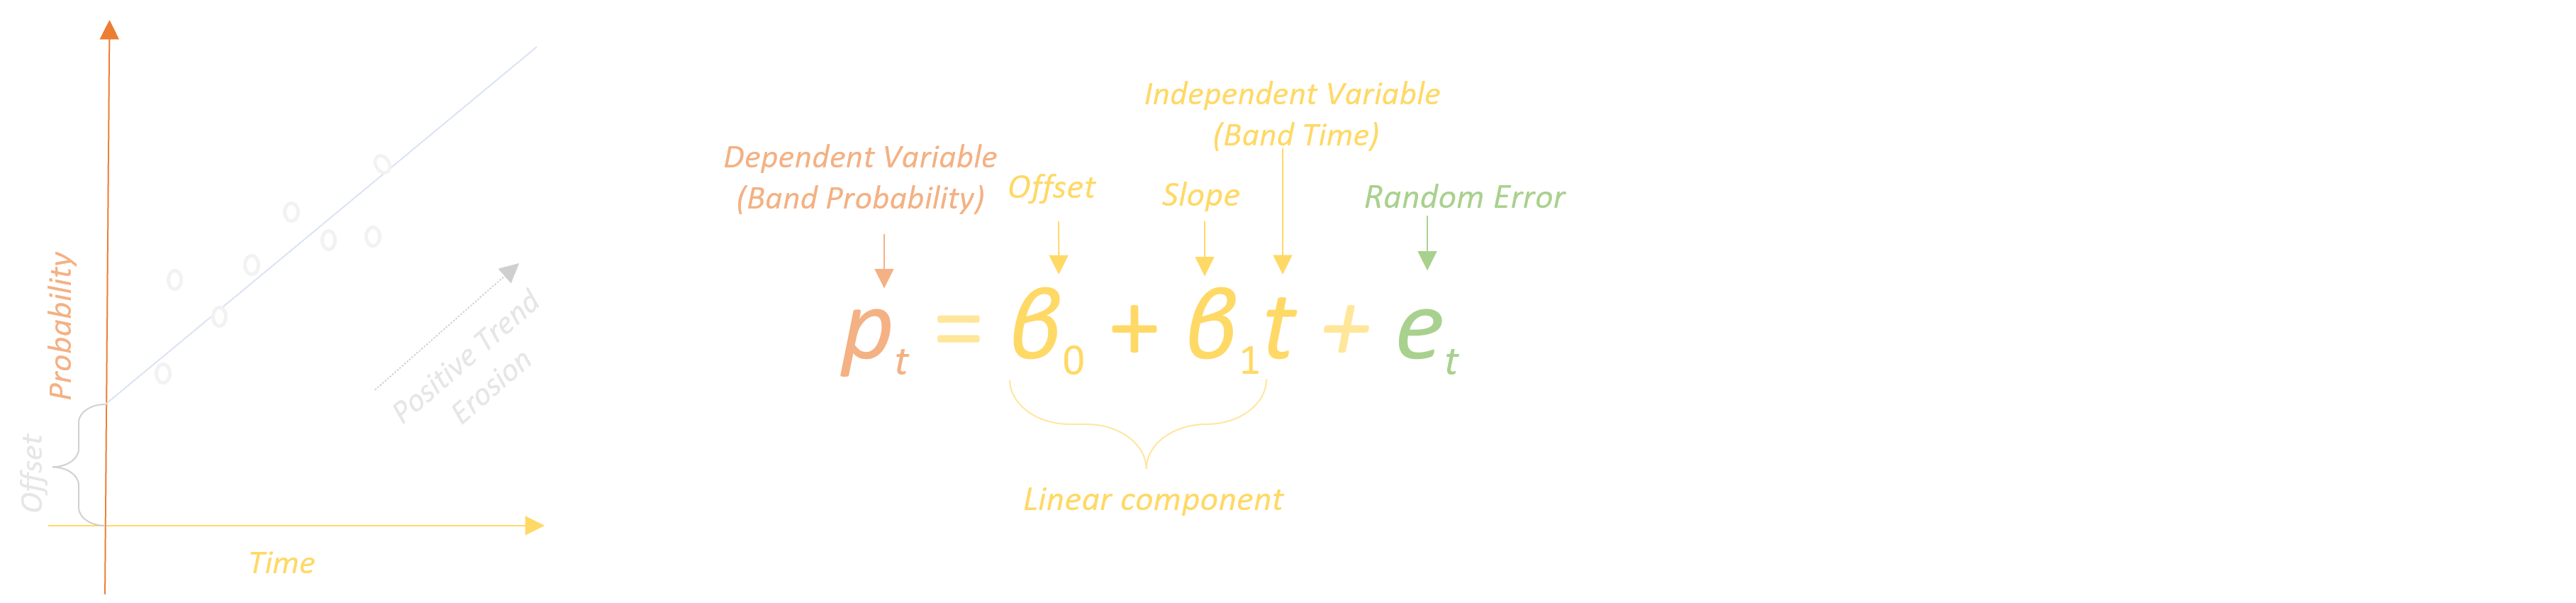

Now, we will start adding the time band. We need to access the time property and encode that as an image.

In [ ]:
# Define the function of adding the time band.
def add_time_band (image):

  # Returns a Date given year, month, day (2017-01-01).
  basedate = ee.Date.fromYMD(2017, 1, 1) 

  # Extract the date from the properties within each image.
  ymd = ee.Date.fromYMD(image.getNumber('year'), image.getNumber('month'), 1)

  # compute the difference between the dates, with units month, and cast as an image.
  time_difference = ee.Image(ymd.difference(basedate, 'month')).float().rename('time')

  # Add a new time band formatted as YYYY-MM-dd.
  return image.addBands(time_difference).set(
      'ymd', ymd.format('YYYY-MM-dd'),
      'system:time_start', ymd.millis()
      )

# Apply that function to our collection.
SWE_time = SWE.map(add_time_band)

In [ ]:
SWE_time

We have added a new band "time", and also set some time properties ('ymd', 'system:time_start').

Now, we will mosaic into nation-wide maps rather than tiles and keep the time properties. Our "tiled" collection will become a collection where there is only 1 image per month.

In [ ]:
# Define the function for creating mosaic for each month.
def mosaic_tiles(unique_month, collection):
  filtered = collection.filter(ee.Filter.eq('ymd', unique_month))
  first_image = filtered.first()
  return filtered.mosaic().copyProperties(
      first_image, ['system:time_start', 'ymd'])

# Get the unique months.
unique_months = SWE_time.aggregate_array('ymd').distinct()

# Apply our mosaic_tiles function using a lambda expression. 
SWE_months = ee.ImageCollection(unique_months.map(lambda month: mosaic_tiles(month, SWE_time)))


The collection is  now ready for our analysis. Let's compute linear regression.
The data should be set up as a two-band input image, where the first band is the independent variable (Time) and the second band is the dependent variable (Probability). 

In [ ]:
# Reduce the collection with the linear fit reducer.
linear_fit = SWE_months.select(['time', 'probability']).reduce(ee.Reducer.linearFit(), 2)

In [ ]:
linear_fit

We can see that after applying the linear fit reducer our image collection has been converted to an image with two bands: scale and offset.

- Scale: Tells us at what rate the water probability is changing. The units are change in water probability per month. This is probably the most interesting band since it tells us which pixels are getting wetter or drier.

- Offset: Tells us where our linear expression crosses the y axis when time difference is 0 (i.e., 2017-01-01)


In [ ]:
# Visualize.
Map = geemap.Map(center=[23, 90], zoom=8, height=900, draw = True)
Map.add_basemap("TERRAIN")
red_blue = ['#ca0020','#FFFFFF00','#0571b0']
Map.addLayer(linear_fit, {'bands': ['offset'], 'min': 0, 'max': 100, 'palette': red_blue},'Linear Reg. (offset)')
Map.addLayer(linear_fit, {'bands': ['scale'], 'min': -2, 'max': 2, 'palette': red_blue},'Linear Reg. (scale)')
Map

## 3.1) Identify erosion areas

Let's focus on erosion (blue colour) as this is likely to be more problematic. 

We can define erosion, using liner regression, as somewhere where:
- scale has increased (it got "wetter").
- offset should be low (originally land).


In [ ]:
# Probability must be increasing (getting wetter).
scale_mask = linear_fit.select('scale').gte(1)

# Offset must have been land in the begginning.
offset_mask = linear_fit.select('offset').lte(50) 

# Combine the masks.
erosion = scale_mask.And(offset_mask)

# Keep only these areas in our visualisation. 
linear_fit_masked = linear_fit.updateMask(erosion)

# Visualise.
Map = geemap.Map(center=[23.35, 90.45], zoom=10, height= 700, draw = True)
Map.add_basemap("TERRAIN")
Map.addLayer(linear_fit, {'bands': ['offset'], 'min': 0, 'max': 100, 'palette': red_blue},'Linear Reg. (offset)', False)
Map.addLayer(linear_fit, {'bands': ['scale'], 'min': -2, 'max': 2, 'palette': red_blue},'Linear Reg. (scale)', False)
Map.addLayer(erosion, {'min': 0, 'max': 1, 'palette': red_blue}, 'erosion mask', False)
Map.addLayer(linear_fit_masked, {'bands': ['offset'], 'min': 0, 'max': 100, 'palette': red_blue},'Erosion (offset)')
Map.addLayer(linear_fit_masked, {'bands': ['scale'], 'min': -3, 'max': 3, 'palette': red_blue},'Erosion (scale)')
Map

We will create a batch task to export the linear_fit image and vector version to your drive.
Export the data to your google drive. 
* It will take ~1-2 hr to obtain these two layers to your drive. 

In [ ]:
# Export raster data.
task = ee.batch.Export.image.toDrive(
            image = linear_fit_masked.select('scale').byte(),
            description = 'Long_LR_erosion_raster',
            folder = 'CTCN-workshop',
            region = AOI,
            scale = 10,
            maxPixels = 10e12,
            fileDimensions= 256*400, 
            shardSize= 256*4,
            formatOptions = {'cloudOptimized': True})
task.start()



or export it as a vector which might be more useful to integrate into existing systems. It will also likely be a much smaller file size.

In [ ]:
# Convert raster to vector.
vector = erosion.selfMask().addBands(
    linear_fit_masked.select('scale')
    ).reduceToVectors(**{
        'reducer': ee.Reducer.mean(), 
        'geometry': AOI, 
        'scale': 10, 
        'eightConnected': True, 
        'labelProperty': 'label', 
        'bestEffort': True, 
        'maxPixels': 10e12, 
        'tileScale': 4
        })
    

# Add an area property in km2
vector = vector.map(lambda f: f.set('area', f.geometry(1).area().divide(1000*1000)))


In [ ]:
# Export vector data.
task = ee.batch.Export.table.toDrive(
            collection = vector,
            description = 'Long_LR_erosion_vector',
            folder = 'CTCN-workshop',
            fileFormat = 'GEOJSON'
            )
task.start()


>**TIP:** Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

## 3.2) Identify areas at risk of erosion

We can take our erosion areas, apply a morphological operation known as an "opening" to remove small pixels, then buffer the remaining areas to identify areas that might be at risk of future erosion.



In [ ]:
## Apply an erosion and then a dilation (also known as 'opening').
## this only creates a buffer around 'at risk' pixels >40m diameter.
erosion_risk = erosion.focal_min(
    radius=20, 
    kernelType='circle', 
    units='meters'
    ).focal_max(
        radius=170, 
        kernelType='circle', 
        units='meters'
        )

## Remove already eroded areas and remove water.
erosion_risk = erosion_risk.updateMask(
            erosion.Not().And(offset_mask)
            ).selfMask() 


In [ ]:
# Visualise.
Map = geemap.Map(center=[23.35, 90.45], zoom=10, height= 700, draw = True)
Map.add_basemap("SATELLITE")
Map.addLayer(AOI, {'color': 'black'}, 'AOI', False)
Map.addLayer(linear_fit, {'bands': ['scale'], 'min': -2, 'max': 2, 'palette': red_blue},'Linear Reg. (scale)', True)
Map.addLayer(erosion, {'min': 0, 'max': 1, 'palette': red_blue},'erosion', False)
Map.addLayer(erosion_risk, {'palette': ['orange']},'Erosion Risk') ## or yellow '#ffff33'
Map

We will create a batch task to export the erosion risk to your drive. This one takes a little longer because the focal operations are fairly compute intensive. 

* It will take ca. 2-3h to obtain this data to your drive. 

In [ ]:
# Export raster data.
task = ee.batch.Export.image.toDrive(
            image = erosion_risk.byte(),
            description = 'erosion_risk',
            folder = 'CTCN-workshop',
            region = AOI,
            scale = 10,
            maxPixels = 10e12,
            fileDimensions= 256*400, 
            shardSize= 256*4,
            formatOptions = {'cloudOptimized': True})
task.start()

# 4) Short term linear regression

We have computed and inspected long-term regression. However, this method is unlikely to identify short term changes because the regression coefficient is a product of the entire time-series (over 3 years). 

We could apply the same method but over a shorter time-period, hereon referred to as short term regression. This will still identify areas getting wetter (or drier), but we will be much more sensitive to recent changes in the environment. This is good, because we can quickly identify areas of erosion, however, it may also be impacted upon by errors in our data such as cloud cover. Therefore, the results must be inspected critically. 

We create a function that computes linear regression for a 3-month period prior to the images current date. We apply this function to all the predictions in our collection, except for the first couple of months where we don't have a 3-month window at the beginning of the time-series. .


In [ ]:
# Linear regression (short term).

n_months = 3 #moving window

def short_term_regression(image):
  image_date = image.date()
  start_date = image_date.advance((n_months - 1) * -1, 'month') #2 months backwards
  end_date = image_date.advance(1, 'day') #1 day ahead of current month.

  # Filtered to include the n_months window size.
  filtered_collection = SWE_months.filterDate(start_date, end_date)
  
  # Compute linear fit.
  short_term_lin_reg = filtered_collection.select(['time', 'probability']).reduce(ee.Reducer.linearFit())

  # Add it to our image.
  return image.addBands(short_term_lin_reg)


# Apply the function to our collection.
earliest_date = ee.Date('2017-01-01').advance(n_months - 1, 'month')

# Filter the collection first to exclude the first few months.
short_term_lin_reg_collection = SWE_months.filterDate(
    earliest_date, '2025-01-01'
    ).map(short_term_regression)


In [ ]:
SWE_months

In [ ]:
short_term_lin_reg_collection

Let's visualise the short term linear regression **collection** we just computed. To do that, we'll use "ymd" time property to filter our collection to an **image** of our interest. Feel free to change the date string to something else.

In [ ]:
# Choose some dates to investigate.
date_filter = '2019-12-01'

short_term_image = ee.Image(
    short_term_lin_reg_collection.filter(
        ee.Filter.eq('ymd', date_filter)
        ).first()
        )


# Visualise it.
Map = geemap.Map(center=[23, 90], zoom=6, height=500, draw = True)
Map.add_basemap("SATELLITE")
Map.addLayer(AOI, {'color': 'black'}, 'AOI')
Map.addLayer(short_term_image, {'bands': ['probability'], 'min': 0, 'max': 100, 'palette': yellow_blue},'Water probability')
Map.addLayer(short_term_image, {'bands': ['offset'], 'min': -100, 'max': 200, 'palette': red_blue},'Linear Reg. (offset)')
Map.addLayer(short_term_image, {'bands': ['scale'], 'min': -20, 'max': 20, 'palette': red_blue},'Linear Reg. (scale)')
Map

In [ ]:
# Export the data to your google drive

task = ee.batch.Export.image.toDrive(
            image = short_term_image.select('scale').int8(),
            description = 'short_term',
            folder = 'CTCN-workshop',
            region = AOI,
            scale = 10,
            maxPixels = 10e12,
            fileDimensions= 256*4*100, 
            shardSize= 256*4,
            formatOptions = {'cloudOptimized': True})

task.start()


>**TIP:** Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

If the short term risk of erosion is more important to you than long term, then it may be worthwhile repeating the "erosion risk" identification we computed earlier. The methodology could remain the same, you just need to apply it to these images instead.